# Date Preparation

In [339]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
color_pal = sns.color_palette()
import itertools
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [340]:
sicknessdata = pd.read_csv("C:/Users/MSI-PC/New project/data/sickness_table.csv")
weather = pd.read_csv("C:/Users/MSI-PC/New project/data/weather.csv")
weather.head()

,time,temperature_2m_max (°C),temperature_2m_min (°C),precipitation_sum (mm),rain_sum (mm),snowfall_sum (cm),precipitation_hours (h),windspeed_10m_max (km/h)
0,4/1/2016,12.1,3.0,0.5,0.5,0.0,3,11.1
1,4/2/2016,15.9,1.2,0.0,0.0,0.0,0,19.2
2,4/3/2016,18.8,5.2,0.0,0.0,0.0,0,12.0
3,4/4/2016,19.4,9.1,0.0,0.0,0.0,0,9.4
4,4/5/2016,21.6,8.6,0.1,0.1,0.0,1,21.5


In [341]:
alldata = pd.concat([sicknessdata, weather], axis=1)

In [342]:
timedata = pd.DataFrame()
timedata['date']=sicknessdata['date']
timedata['calls']=sicknessdata['calls']
timedata['temp_max']=weather['temperature_2m_max (°C)']
timedata['sby_need']=sicknessdata['sby_need']
timedata=timedata.set_index('date')
timedata.index = pd.to_datetime(timedata.index)
timedata.head()

,calls,temp_max,sby_need
date,,,
2016-04-01,8154.0,12.1,4.0
2016-04-02,8526.0,15.9,70.0
2016-04-03,8088.0,18.8,0.0
2016-04-04,7044.0,19.4,0.0
2016-04-05,7236.0,21.6,0.0


<AxesSubplot:ylabel='Frequency'>

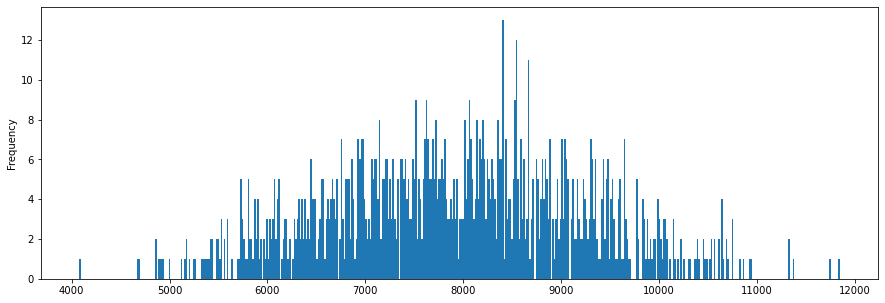

In [343]:
fig, ax=plt.subplots(figsize=(15,5))
timedata['calls'].plot(kind='hist', bins=500)

removing the outliers from the data to reduce the noise in the modeling stage

<AxesSubplot:ylabel='Frequency'>

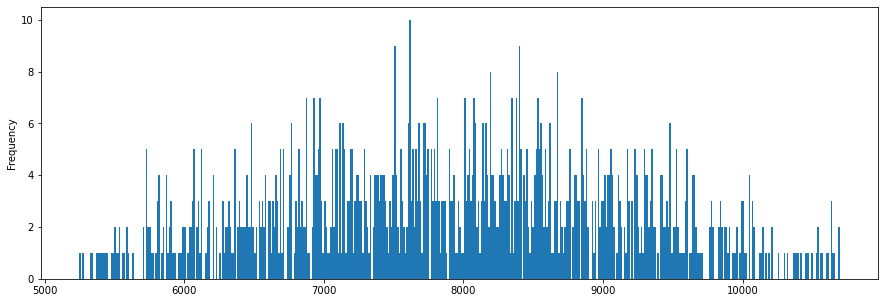

In [344]:
#removing outliers from the data
timedata.drop(timedata[timedata['calls'] >= 10700].index, inplace = True)
timedata.drop(timedata[timedata['calls'] < 5200].index, inplace = True)
fig, ax=plt.subplots(figsize=(15,5))
timedata['calls'].plot(kind='hist', bins=500)

<AxesSubplot:title={'center':'calls'}, xlabel='date'>

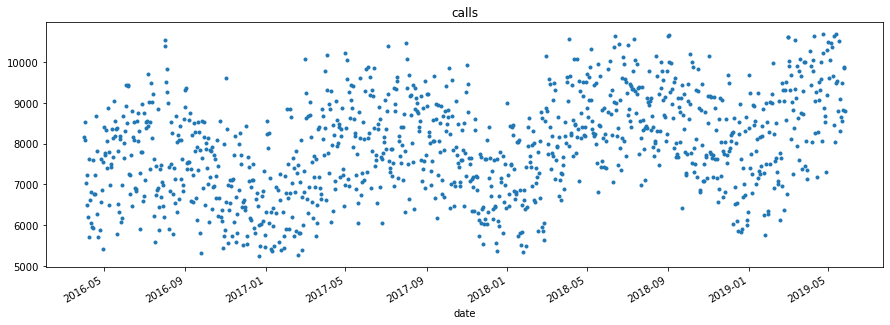

In [345]:
timedata['calls'].plot(style='.', figsize=(15,5), title='calls')

<function matplotlib.pyplot.show(close=None, block=None)>

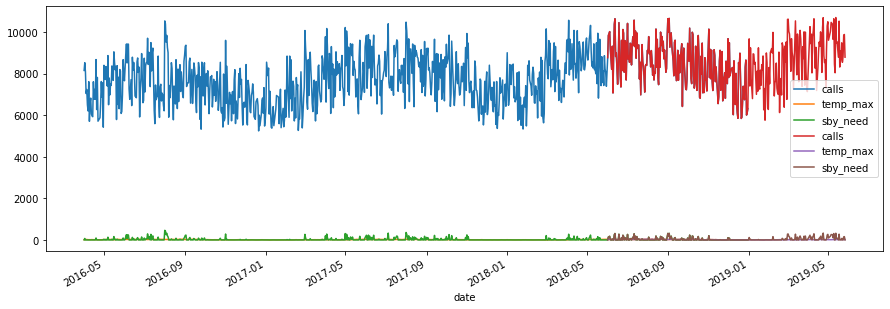

In [346]:

#sepleting the data into training and testing data
train = timedata.loc[timedata.index < '01-01-2019']
test = timedata.loc[timedata.index >= '06-01-2018']

fig, ax=plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='trainig set')
test.plot(ax=ax, label='testing set')
plt.show

In [347]:
#extracting featuered data from date such as month, weeks, weekends etc.
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.week
    return df

timedata=create_features(timedata)
timedata.head()

<ipython-input-347-50872c9555d7>:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.week


,calls,temp_max,sby_need,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,
2016-04-01,8154.0,12.1,4.0,4,2,4,2016,92,1,13
2016-04-02,8526.0,15.9,70.0,5,2,4,2016,93,2,13
2016-04-03,8088.0,18.8,0.0,6,2,4,2016,94,3,13
2016-04-04,7044.0,19.4,0.0,0,2,4,2016,95,4,14
2016-04-05,7236.0,21.6,0.0,1,2,4,2016,96,5,14


In [351]:
# adding data features to the training and testing data sets

train = create_features(train)
test = create_features(test)


FEATURES = ['weekofyear','dayofyear','dayofweek', 'month', 'year','quarter','dayofmonth','temp_max']
TARGET = 'calls'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

<ipython-input-347-50872c9555d7>:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.week


In [352]:
#creating the model
reg = xgb.XGBRegressor(base_score=0.05, booster='gbtree',    
                       n_estimators=100000,
#                        early_stopping_rounds=50,
                       
#                        objective='reg:linear',
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:7896.51429	validation_1-rmse:8604.13998
[100]	validation_0-rmse:7160.58391	validation_1-rmse:7846.25356
[200]	validation_0-rmse:6495.66282	validation_1-rmse:7160.20746
[300]	validation_0-rmse:5895.18797	validation_1-rmse:6541.37092
[400]	validation_0-rmse:5353.01606	validation_1-rmse:5978.05757
[500]	validation_0-rmse:4863.49225	validation_1-rmse:5468.40388
[600]	validation_0-rmse:4421.76260	validation_1-rmse:5004.84198
[700]	validation_0-rmse:4023.41267	validation_1-rmse:4588.99444
[800]	validation_0-rmse:3664.43896	validation_1-rmse:4216.86855
[900]	validation_0-rmse:3341.07136	validation_1-rmse:3888.48993
[1000]	validation_0-rmse:3049.75717	validation_1-rmse:3582.15382
[1100]	validation_0-rmse:2787.91494	validation_1-rmse:3306.06724
[1200]	validation_0-rmse:2552.91613	validation_1-rmse:3057.72039
[1300]	validation_0-rmse:2342.17009	validation_1-rmse:2834.54213
[1400]	validation_0-rmse:2153.58708	validation_1-rmse:2634.49208
[1500]	validation_0-rmse:1985.25398	v

[12900]	validation_0-rmse:700.54866	validation_1-rmse:930.97371
[13000]	validation_0-rmse:699.72285	validation_1-rmse:930.60543
[13100]	validation_0-rmse:698.87411	validation_1-rmse:930.29710
[13200]	validation_0-rmse:698.01933	validation_1-rmse:929.88771
[13300]	validation_0-rmse:697.12544	validation_1-rmse:929.41127
[13400]	validation_0-rmse:696.26380	validation_1-rmse:928.96186
[13500]	validation_0-rmse:695.40381	validation_1-rmse:928.53519
[13600]	validation_0-rmse:694.52100	validation_1-rmse:928.13236
[13700]	validation_0-rmse:693.57245	validation_1-rmse:927.74693
[13800]	validation_0-rmse:692.64398	validation_1-rmse:927.30312
[13900]	validation_0-rmse:691.80270	validation_1-rmse:926.97229
[14000]	validation_0-rmse:691.00791	validation_1-rmse:926.65717
[14100]	validation_0-rmse:690.22482	validation_1-rmse:926.34142
[14200]	validation_0-rmse:689.51111	validation_1-rmse:926.06387
[14300]	validation_0-rmse:688.77717	validation_1-rmse:925.77302
[14400]	validation_0-rmse:688.05044	vali

[25800]	validation_0-rmse:612.32769	validation_1-rmse:905.30898
[25900]	validation_0-rmse:611.79280	validation_1-rmse:905.23779
[26000]	validation_0-rmse:611.22340	validation_1-rmse:905.10397
[26100]	validation_0-rmse:610.61807	validation_1-rmse:904.87660
[26200]	validation_0-rmse:610.03664	validation_1-rmse:904.68871
[26300]	validation_0-rmse:609.40756	validation_1-rmse:904.42448
[26400]	validation_0-rmse:608.79940	validation_1-rmse:904.20164
[26500]	validation_0-rmse:608.18496	validation_1-rmse:903.92714
[26600]	validation_0-rmse:607.56508	validation_1-rmse:903.69907
[26700]	validation_0-rmse:607.02978	validation_1-rmse:903.53749
[26800]	validation_0-rmse:606.50553	validation_1-rmse:903.36661
[26900]	validation_0-rmse:605.93536	validation_1-rmse:903.17981
[27000]	validation_0-rmse:605.46238	validation_1-rmse:903.05284
[27100]	validation_0-rmse:604.98528	validation_1-rmse:902.89732
[27200]	validation_0-rmse:604.52262	validation_1-rmse:902.76462
[27300]	validation_0-rmse:604.06172	vali

[38700]	validation_0-rmse:549.57351	validation_1-rmse:884.57776
[38800]	validation_0-rmse:549.17067	validation_1-rmse:884.45069
[38900]	validation_0-rmse:548.76580	validation_1-rmse:884.31137
[39000]	validation_0-rmse:548.38066	validation_1-rmse:884.18388
[39100]	validation_0-rmse:547.94059	validation_1-rmse:883.98169
[39200]	validation_0-rmse:547.49196	validation_1-rmse:883.74415
[39300]	validation_0-rmse:547.07168	validation_1-rmse:883.52823
[39400]	validation_0-rmse:546.64126	validation_1-rmse:883.33171
[39500]	validation_0-rmse:546.21805	validation_1-rmse:883.16108
[39600]	validation_0-rmse:545.80933	validation_1-rmse:883.07586
[39700]	validation_0-rmse:545.32763	validation_1-rmse:883.04184
[39800]	validation_0-rmse:544.98885	validation_1-rmse:882.91844
[39900]	validation_0-rmse:544.61056	validation_1-rmse:882.80621
[40000]	validation_0-rmse:544.26492	validation_1-rmse:882.71733
[40100]	validation_0-rmse:543.92148	validation_1-rmse:882.64491
[40200]	validation_0-rmse:543.55292	vali

[51600]	validation_0-rmse:505.06145	validation_1-rmse:875.26699
[51700]	validation_0-rmse:504.77371	validation_1-rmse:875.22256
[51800]	validation_0-rmse:504.55149	validation_1-rmse:875.23270
[51900]	validation_0-rmse:504.34595	validation_1-rmse:875.27807
[52000]	validation_0-rmse:504.08624	validation_1-rmse:875.34247
[52100]	validation_0-rmse:503.81585	validation_1-rmse:875.39624
[52200]	validation_0-rmse:503.53238	validation_1-rmse:875.44436
[52300]	validation_0-rmse:503.26800	validation_1-rmse:875.50891
[52400]	validation_0-rmse:503.02392	validation_1-rmse:875.52174
[52500]	validation_0-rmse:502.79428	validation_1-rmse:875.52800
[52600]	validation_0-rmse:502.60080	validation_1-rmse:875.45708
[52700]	validation_0-rmse:502.35622	validation_1-rmse:875.40084
[52800]	validation_0-rmse:502.11740	validation_1-rmse:875.33671
[52900]	validation_0-rmse:501.91582	validation_1-rmse:875.32941
[53000]	validation_0-rmse:501.75528	validation_1-rmse:875.33464
[53100]	validation_0-rmse:501.61084	vali

[64500]	validation_0-rmse:472.93630	validation_1-rmse:874.10577
[64600]	validation_0-rmse:472.66559	validation_1-rmse:873.98413
[64700]	validation_0-rmse:472.43870	validation_1-rmse:873.97759
[64800]	validation_0-rmse:472.17251	validation_1-rmse:873.93289
[64900]	validation_0-rmse:471.90890	validation_1-rmse:873.84408
[65000]	validation_0-rmse:471.65203	validation_1-rmse:873.75330
[65100]	validation_0-rmse:471.41225	validation_1-rmse:873.77289
[65200]	validation_0-rmse:471.16979	validation_1-rmse:873.79108
[65300]	validation_0-rmse:470.94533	validation_1-rmse:873.80966
[65400]	validation_0-rmse:470.70970	validation_1-rmse:873.79016
[65500]	validation_0-rmse:470.45397	validation_1-rmse:873.78760
[65600]	validation_0-rmse:470.22425	validation_1-rmse:873.78292
[65700]	validation_0-rmse:469.97824	validation_1-rmse:873.75988
[65800]	validation_0-rmse:469.72062	validation_1-rmse:873.73326
[65900]	validation_0-rmse:469.45705	validation_1-rmse:873.71344
[66000]	validation_0-rmse:469.20957	vali

[77400]	validation_0-rmse:437.04599	validation_1-rmse:868.48685
[77500]	validation_0-rmse:436.75181	validation_1-rmse:868.43971
[77600]	validation_0-rmse:436.45991	validation_1-rmse:868.42132
[77700]	validation_0-rmse:436.15376	validation_1-rmse:868.39255
[77800]	validation_0-rmse:435.82980	validation_1-rmse:868.39724
[77900]	validation_0-rmse:435.52405	validation_1-rmse:868.38576
[78000]	validation_0-rmse:435.23148	validation_1-rmse:868.39133
[78100]	validation_0-rmse:434.92155	validation_1-rmse:868.34325
[78200]	validation_0-rmse:434.61854	validation_1-rmse:868.26428
[78300]	validation_0-rmse:434.31884	validation_1-rmse:868.17034
[78400]	validation_0-rmse:434.03045	validation_1-rmse:868.02510
[78500]	validation_0-rmse:433.71882	validation_1-rmse:867.94247
[78600]	validation_0-rmse:433.43521	validation_1-rmse:867.91317
[78700]	validation_0-rmse:433.16338	validation_1-rmse:867.83335
[78800]	validation_0-rmse:432.90092	validation_1-rmse:867.72681
[78900]	validation_0-rmse:432.58299	vali

[90300]	validation_0-rmse:400.83454	validation_1-rmse:860.41106
[90400]	validation_0-rmse:400.58885	validation_1-rmse:860.37602
[90500]	validation_0-rmse:400.34522	validation_1-rmse:860.33329
[90600]	validation_0-rmse:400.11981	validation_1-rmse:860.26179
[90700]	validation_0-rmse:399.88598	validation_1-rmse:860.22873
[90800]	validation_0-rmse:399.65625	validation_1-rmse:860.16685
[90900]	validation_0-rmse:399.39427	validation_1-rmse:860.02578
[91000]	validation_0-rmse:399.12370	validation_1-rmse:859.90044
[91100]	validation_0-rmse:398.84163	validation_1-rmse:859.77215
[91200]	validation_0-rmse:398.56532	validation_1-rmse:859.64214
[91300]	validation_0-rmse:398.31226	validation_1-rmse:859.59153
[91400]	validation_0-rmse:398.08218	validation_1-rmse:859.54021
[91500]	validation_0-rmse:397.88886	validation_1-rmse:859.54798
[91600]	validation_0-rmse:397.68277	validation_1-rmse:859.44581
[91700]	validation_0-rmse:397.46726	validation_1-rmse:859.34293
[91800]	validation_0-rmse:397.28116	vali

XGBRegressor(base_score=0.05, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

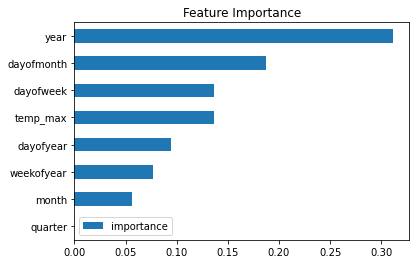

In [353]:
# figure out the importance of each parameter of the input data
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [354]:
# testing the model with testing data
test['prediction'] = reg.predict(X_test)
test.head()

,calls,temp_max,sby_need,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
date,,,,,,,,,,,
2018-06-02,8766.0,22.7,0.0,5,2,6,2018,153,2,22,9074.838867
2018-06-03,9834.0,24.0,138.0,6,2,6,2018,154,3,22,9158.941406
2018-06-05,10020.0,22.9,175.0,1,2,6,2018,156,5,23,9651.290039
2018-06-06,9180.0,23.6,13.0,2,2,6,2018,157,6,23,9524.716797
2018-06-07,8718.0,27.3,0.0,3,2,6,2018,158,7,23,8755.754883


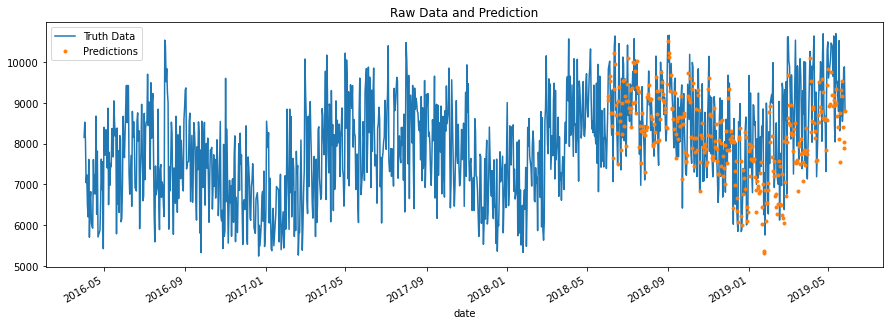

In [355]:
#ploting the pridicted data vs. the actual data
timedata = timedata.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = timedata[['calls']].plot(figsize=(15, 5))
timedata['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

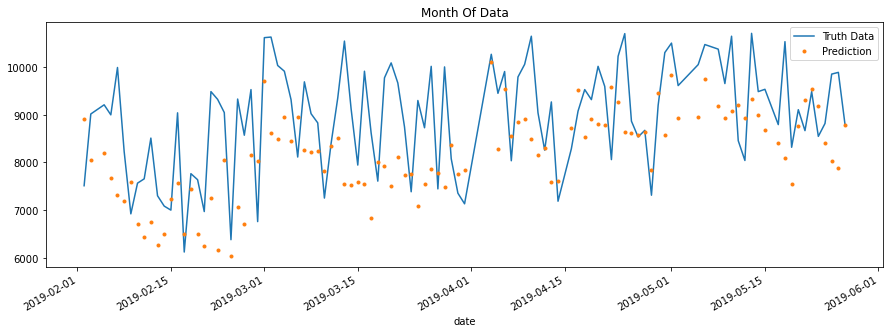

In [356]:
#ploting the data zoomed to clearfy the pridiction pattern at depth
ax = timedata.loc[(timedata.index > '02-01-2019') & (timedata.index < '07-30-2019')]['calls'] \
    .plot(figsize=(15, 5), title='Month Of Data')
timedata.loc[(timedata.index > '02-01-2019') & (timedata.index < '07-30-2019')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

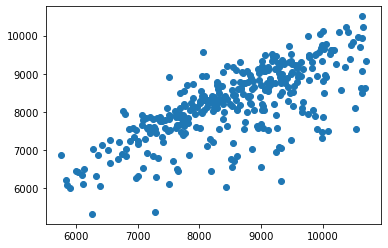

In [357]:
# scatter plot of the actual vs. pridicted data
plt.scatter(test["calls"],test["prediction"])
plt.show()

In [358]:
# calculating the RMSE value
score = np.sqrt(mean_squared_error(test['calls'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 854.68


In [359]:
#calculating R-Squared value
print("R-Sequared :",r2_score(test["calls"].values,test["prediction"].values))

R-Sequared : 0.4198873359111669


In [360]:
#save the model
reg.save_model('XGBmodel2.json')

# Second Model (calls vs. sby_need) 

as we figured out in the EDA section the relationship between calls and sby_need is exponential

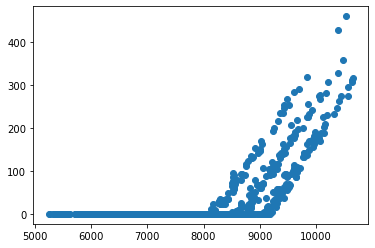

In [292]:
# viewing the data on scatter plot
plt.scatter(train["calls"],train["sby_need"])
plt.show()

## from the scatter plot we get that if the number of calls is less than 8000 the sby_need will be zero


#### we need to remove all the sby_need zero values and then we figure out the best fitting model of the values larger than 8000 calls

In [293]:
# removing the sby_need zero values 
# train = train[train['sby_need'] != 0]
train.head()

,calls,temp_max,sby_need,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,
2016-04-01,8154.0,12.1,4.0,4,2,4,2016,92,1,13
2016-04-02,8526.0,15.9,70.0,5,2,4,2016,93,2,13
2016-04-03,8088.0,18.8,0.0,6,2,4,2016,94,3,13
2016-04-04,7044.0,19.4,0.0,0,2,4,2016,95,4,14
2016-04-05,7236.0,21.6,0.0,1,2,4,2016,96,5,14


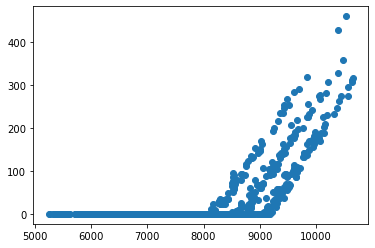

In [294]:
# exploring the remaining data
plt.scatter(train["calls"],train["sby_need"])
plt.show()

there are 3 trends in the scatter plot we need to figure out the effect that has made the difference between these trend.

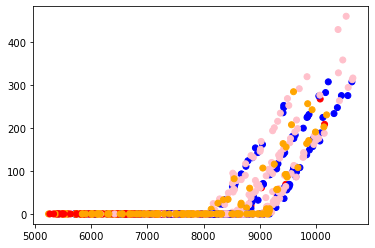

In [295]:
#first we try with the quarter value
train["xcolors"]=train['quarter'].replace([1,2,3,4],["red","blue","pink","orange"])
plt.scatter(train["calls"],train["sby_need"],color=train['xcolors'])
plt.show()

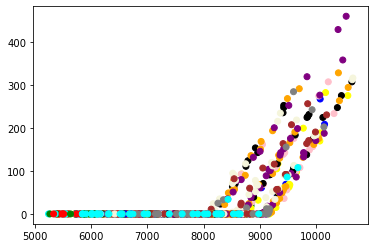

In [296]:
#first we try with the month value
train["mcolors"]=train['month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan"])
plt.scatter(train["calls"],train["sby_need"],color=train['mcolors'])
plt.show()

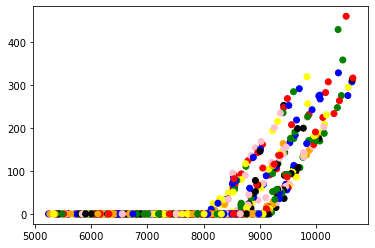

In [297]:
#first we try with the day of week value
train["wcolors"]=train['dayofweek'].replace([0,1,2,3,4,5,6],["red","green","blue","yellow","pink","black","orange"])
plt.scatter(train["calls"],train["sby_need"],color=train['wcolors'])
plt.show()

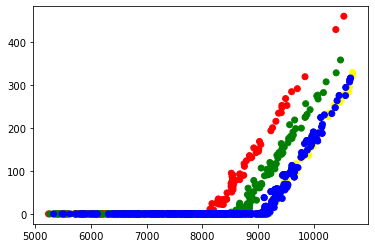

In [298]:
# trying trim the data
fig, ax = plt.subplots()
train["ycolors"]=train['year'].replace([2016,2017,2018,2019],["red","green","blue","yellow"])
test["ycolors"]=test['year'].replace([2016,2017,2018,2019],["red","green","blue","yellow"])
plt.scatter(test["calls"],test["sby_need"],color=test['ycolors'])
plt.scatter(train["calls"],train["sby_need"],color=train['ycolors'])
plt.show()
# train.head(50)

### As shown in the scatter plot above, there is a different trend for each of 2016, 2017, and both 2018-2019 together, from a bussines insight, the model should depend on the trend of the 2018-2019 data and after using the model for couple of months or even a year or more, it needs to do review again to the model accurcecy and the change in the trend. so for the forcasted "sby_need" it will be zero if it is less than 9000 and follow the following linear model if it is more than 9000.

In [312]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#regression model for 2018-2019
test = test[test['sby_need'] != 0]
x = pd.DataFrame(test['calls'])
y = pd.DataFrame(test['sby_need'])
rx_train, rx_test, ry_train, ry_test = train_test_split(x,y, test_size=0.3, random_state=1)
print(rx_train.shape)
print(rx_test.shape)
print(ry_train.shape)
print(ry_test.shape)

(82, 1)
(36, 1)
(82, 1)
(36, 1)


In [317]:
# building the regression model
reg_1819 = LinearRegression()
reg_1819.fit(rx_train, ry_train)
print('intercept = ',reg_1819.intercept_)
print('slop = ',reg_1819.coef_)

intercept =  [-1802.21110537]
slop =  [[0.19802929]]


### y = 0.198 * x - 1802

In [326]:
#testing the model
y_pred = (0.198 * rx_test) - 1802
print("R-Sequared :",r2_score(ry_test["sby_need"].values,y_pred["calls"].values))

R-Sequared : 0.9762226607851413


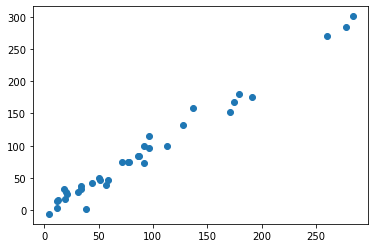

In [327]:
#plot the test data
plt.scatter(ry_test["sby_need"],y_pred["calls"])

In [328]:
# testing the number of 9000
y9000 = (0.198 * 9000) - 1802
y9000

-20.0

In [338]:
# it needed to reach the first number at which the prediction is zero
#second try
y9102 = (0.198 * 9102) - 1802
y9102

0.19600000000014006

### the final result is: if the number of calls below 9102 the sby_need will be zero and if the number of call is more than 9102 the following equation should be used to find the sby_need.
### y = 0.198 * x -1802